In [1]:
import os
from math import pi

# Use 8 CPU devices
# os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"  # Use only the first GPU
from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit, pmap
from jax import random

# jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, MN_POTENTIAL, NFW_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

In [2]:
jax.devices()

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]

In [3]:
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental import shard_map
from jax.sharding import NamedSharding

# Create a mesh from all devices
devices = jax.devices()
mesh = Mesh(devices, axis_names=('N_particles',))
sharding = NamedSharding(mesh, P('N_particles')) 

#  # jitting and device_put does weird stuff with what is put where
@partial(jit, static_argnames=('sharding'))
def shard_positions_with_shard_map(positions, sharding):
    """
    Shards positions across available devices along axis 0 using shard_map.
    
    Args:
        positions: Array of shape (n, d) to be sharded
        
    Returns:
        Tuple of (sharded_positions, mesh, sharding)
    """
    
    
    # Shard the positions array
    sharded_positions = jax.device_put(positions, sharding)
    
    return sharded_positions


In [4]:
code_length = 10.0 * u.kpc
code_mass = 1e8 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)


# Define the 
config = SimulationConfig(N_particles = 10_000, 
                          return_snapshots = True, 
                          num_snapshots = 50, 
                          num_timesteps = 200, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL,  ), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                        #   double_map = True,
                          # batch_size = 25_000, 
                          softening = (0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (5000 * u.Myr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                           MN_params= MNParams(M=(6.5e10 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.3 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (15.0 * u.kpc).to(code_units.code_length).value,
                                               c = 8.0),                           
                          G=G, ) 

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#put the Plummer sphere in a ciruclar orbit around the NFW halo
rp=200*u.kpc.to(code_units.code_length)


#sampling the center of mass on the sphere
key = random.PRNGKey(43)
num_samples = 1                                             # Number of positions to generate, we only care about the center of mass
pos_com = sample_position_on_circle(key, rp, num_samples)   # Sample the position of the center of mass on a circle of radius rp
inclination = jnp.radians(40)                               # 30-degree inclination of the orbit
pos_com = inclined_position(pos_com, inclination)           # Rotate the center of mass position by the inclination angle
vel_com = jnp.zeros_like(pos_com)                           # Initialize velocities to zero, it dosen't matter because the acceleration depend only on the postion
state_com = construct_initial_state(pos_com, vel_com)

# Calculate the acceleration at the center of mass, because v_c = sqrt(rp*a) in circular motion
acc_com = MyamotoNagai(state_com, config, params, return_potential=False) + NFW(state_com, config, params, return_potential=False)
acc_com += NFW(state_com, config, params, return_potential=False)  # Add the acceleration from the NFW halo
#modulus of the circular velocity at the center of mass
v_c = jnp.sqrt(jnp.linalg.norm(acc_com, axis=1) * rp)
#bulk motion to give to each particle of the Plummer sphere
vel_com = inclined_circular_velocity(pos_com, v_c, inclination)


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state = construct_initial_state(positions, velocities)




In [5]:
shard_position = jax.device_put(positions, sharding)
print(shard_position.devices())
jax.debug.visualize_array_sharding(shard_position)

{CudaDevice(id=1), CudaDevice(id=0), CudaDevice(id=3), CudaDevice(id=2)}


         
  GPU 0  
         
         
  GPU 1  
         
         
  GPU 2  
         
         
  GPU 3  
         

In [6]:
# distance = jnp.linalg.norm(shard_position - shard_position[:, None, :], axis=2)
# jax.debug.visualize_array_sharding(distance)

In [7]:
#let's shard position, velocity and mass
shard_inital_state = jax.device_put(initial_state, sharding)
print(shard_inital_state.shape)
print(shard_inital_state.devices())

shard_mass = jax.device_put(mass, sharding)
print(shard_mass.shape)
print(shard_mass.devices())


(10000, 2, 3)
{CudaDevice(id=1), CudaDevice(id=0), CudaDevice(id=3), CudaDevice(id=2)}
(10000,)
{CudaDevice(id=1), CudaDevice(id=0), CudaDevice(id=3), CudaDevice(id=2)}


In [8]:
del initial_state
del mass
del positions
del velocities

In [9]:
#lets's try to integrate now
snapshots = jax.block_until_ready(time_integration(shard_inital_state, shard_mass, config, params))

In [10]:
snapshots.states.devices()

{CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)}

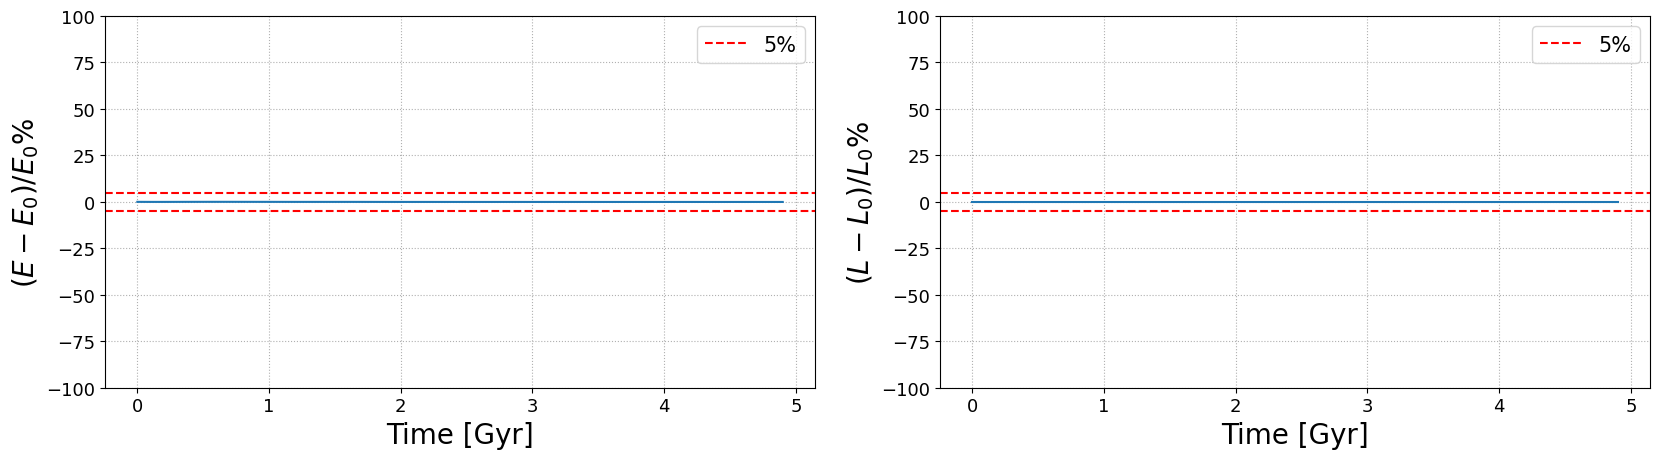

In [11]:
energy_angular_momentum_plot(snapshots, code_units,)

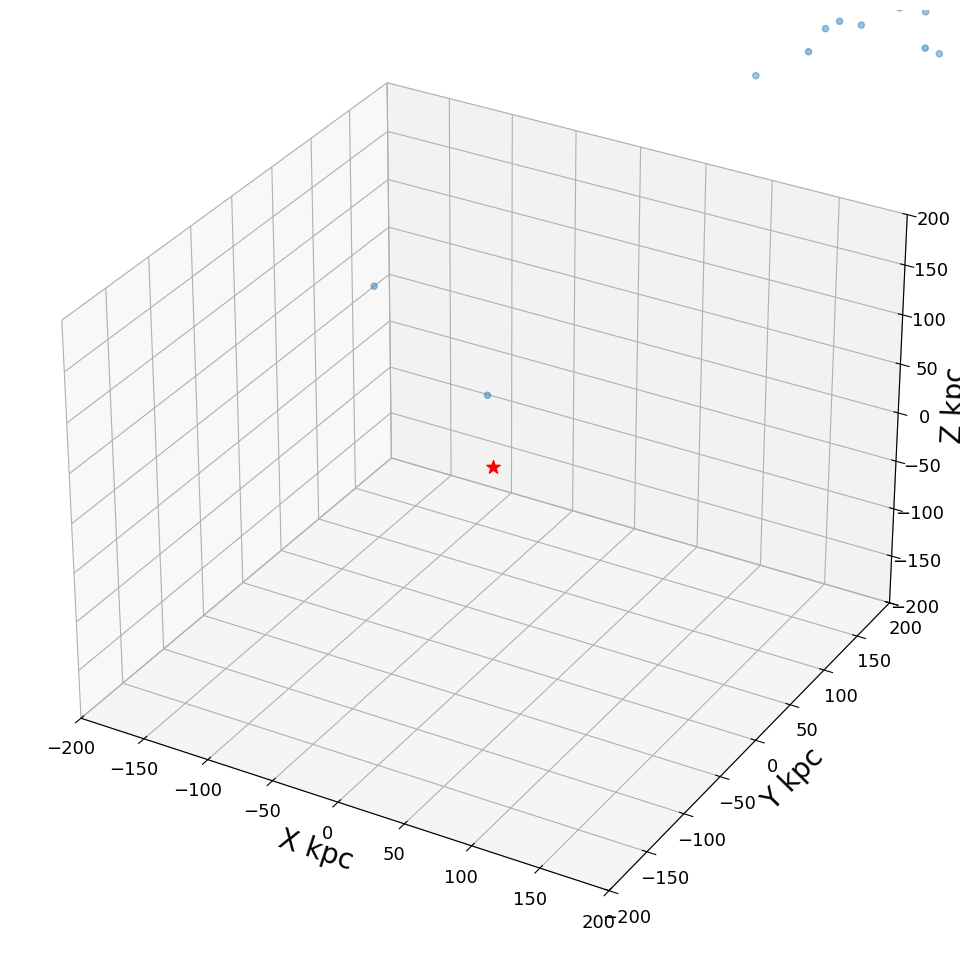

In [12]:
from odisseo.visualization import plot_last_snapshot    
plot_last_snapshot(snapshots=snapshots, code_units=code_units, rp=rp, plotting_units_length=u.kpc)


In [13]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# for i in range(0, snapshots.states.shape[0], 5):
#     ax.scatter(snapshots.states[i, :, 0, 0], snapshots.states[i, :, 0, 1], snapshots.states[i, :, 0, 2], s=1, label=f'{i}')
# ax.scatter(0, 0, 0, c='red', s=100, )
# ax.set_xlabel('X [kpc]')
# ax.set_ylabel('Y [kpc]')
# ax.set_zlabel('Z [kpc]')
# # ax.set_xlim(-rp, rp)
# # ax.set_ylim(-rp, rp)
# # ax.set_zlim(-rp, rp)
# ax.legend()

In [14]:
# fig = plt.figure(tight_layout=True, figsize=(10, 5))
# ax = fig.add_subplot(111, )
# for i in range(0, snapshots.states.shape[0], 5):
#     ax.hist(jnp.linalg.norm(snapshots.states[i, :, 1], axis=1), label=f'{i}', histtype='step', bins=100)
# ax.set_xlabel('$\sigma_v$[km/s]')
# ax.legend()

In [15]:
(0.3 * 150_000)/3600

12.5